In [1]:
import pandas as pd

diff_raw = pd.read_csv(
    "../../buschmais-spring-petclinic_fork/git_diff.log",
    sep="\n",
    names=["raw"],
    skip_blank_lines=False)
diff_raw.head(10)

,raw
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
1,Author: Antoine Rey <antoine.rey@gmail.com>
2,Date: Fri Aug 19 18:54:56 2016 +0200
3,NaN
4,Convert Controler's integration test to un...
5,NaN
6,diff --git a/src/test/java/org/springframework...
7,index ee83b8a..a83255b 100644
8,--- a/src/test/java/org/springframework/sample...
9,+++ b/src/test/java/org/springframework/sample...


In [2]:
i = diff_raw.raw.str.startswith("index")
ignored_rows = ~(i.shift(1) | i.shift(2))
diff_raw = diff_raw[ignored_rows]
diff_raw.head()

,raw
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5
1,Author: Antoine Rey <antoine.rey@gmail.com>
2,Date: Fri Aug 19 18:54:56 2016 +0200
3,NaN
4,Convert Controler's integration test to un...


In [3]:
diff_raw['commit'] = diff_raw.raw.str.split("^commit ").str[1]
diff_raw['timestamp'] = pd.to_datetime(diff_raw.raw.str.split("^Date: ").str[1])
diff_raw['path'] = diff_raw.raw.str.extract(
    "^diff --git.* b/(.*)", expand=True)[0]
diff_raw.head()

,raw,commit,timestamp,path
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,NaN,NaT,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,NaN,2016-08-19 16:54:56,NaN
3,NaN,NaN,NaT,NaN
4,Convert Controler's integration test to un...,NaN,NaT,NaN


In [4]:
diff_raw = diff_raw.fillna(method='ffill')
diff_raw.head()

,raw,commit,timestamp,path
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN
3,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN
4,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN


In [5]:
diff_raw['line'] = diff_raw.raw.str.replace("\t", "    ")
diff_raw['added'] = diff_raw.line.str.extract("^\+( *).*$", expand=True)[0].str.len()
diff_raw['deleted'] = diff_raw.line.str.extract("^-( *).*$", expand=True)[0].str.len()
diff_raw.head()

,raw,commit,timestamp,path,line,added,deleted
0,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,commit e5254156eca3a8461fa758f17dc5fae27e738ab5,NaN,NaN
1,Author: Antoine Rey <antoine.rey@gmail.com>,e5254156eca3a8461fa758f17dc5fae27e738ab5,NaT,NaN,Author: Antoine Rey <antoine.rey@gmail.com>,NaN,NaN
2,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Date: Fri Aug 19 18:54:56 2016 +0200,NaN,NaN
3,Date: Fri Aug 19 18:54:56 2016 +0200,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Date: Fri Aug 19 18:54:56 2016 +0200,NaN,NaN
4,Convert Controler's integration test to un...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,NaN,Convert Controler's integration test to un...,NaN,NaN


In [6]:
diff = \
    diff_raw[
        (~diff_raw['added'].isnull()) | 
             (~diff_raw['deleted'].isnull())].copy()
diff.head()

,raw,commit,timestamp,path,line,added,deleted
13,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0
14,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0
15,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0
23,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN
24,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN


In [7]:
diff['is_comment'] = diff.line.str[1:].str.match(r' *(//|/*\*).*')
diff['is_empty'] = diff.line.str[1:].str.replace(" ","").str.len() == 0
diff['is_source'] = ~(diff['is_empty'] | diff['is_comment'])
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source
13,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True
14,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True
15,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0,False,True,False
23,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True
24,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True


In [8]:
diff.raw.str[0].value_counts()

+    15770
-    11800
Name: raw, dtype: int64

In [9]:
diff['lines_added'] = (~diff.added.isnull()).astype('int')
diff['lines_deleted'] = (~diff.deleted.isnull()).astype('int')
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
13,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True,0,1
14,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,NaN,0.0,False,False,True,0,1
15,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,NaN,0.0,False,True,False,0,1
23,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True,1,0
24,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,NaN,False,False,True,1,0


In [10]:
diff = diff.fillna(0)
diff.to_excel("temp.xlsx")
diff.head()

,raw,commit,timestamp,path,line,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
13,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,0.0,0.0,False,False,True,0,1
14,-import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-import static org.springframework.test.web.se...,0.0,0.0,False,False,True,0,1
15,-,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,-,0.0,0.0,False,True,False,0,1
23,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,0.0,False,False,True,1,0
24,+import static org.springframework.test.web.se...,e5254156eca3a8461fa758f17dc5fae27e738ab5,2016-08-19 16:54:56,src/test/java/org/springframework/samples/petc...,+import static org.springframework.test.web.se...,0.0,0.0,False,False,True,1,0


In [11]:
commits_per_day = diff.set_index('timestamp').resample("D").sum()
commits_per_day.head()

,added,deleted,is_comment,is_empty,is_source,lines_added,lines_deleted
timestamp,,,,,,,
2009-05-05,644.0,12.0,0.0,87.0,195.0,278,4
2009-05-06,988.0,684.0,2.0,184.0,436.0,357,265
2009-05-07,612.0,48.0,1.0,60.0,138.0,189,10
2009-05-08,0.0,0.0,0.0,0.0,0.0,0,0
2009-05-09,0.0,0.0,0.0,0.0,0.0,0,0


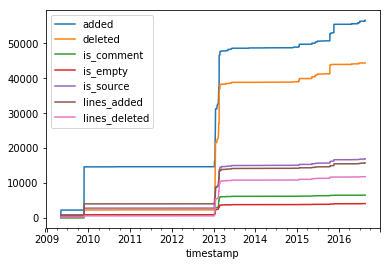

In [12]:
%matplotlib inline
commits_per_day.cumsum().plot()

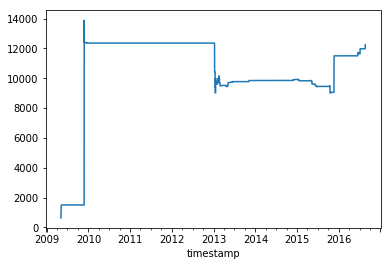

In [13]:
(commits_per_day.added - commits_per_day.deleted).cumsum().plot()

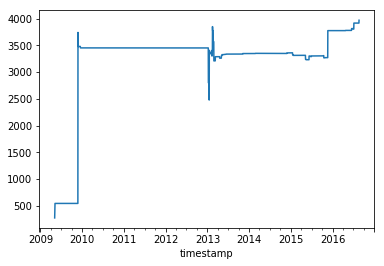

In [14]:
(commits_per_day.lines_added - commits_per_day.lines_deleted).cumsum().plot()

In [15]:
diff_sum = diff.sum()
diff_sum.lines_added - diff_sum.lines_deleted                                                    

3970

In [16]:
3913

3913